In [1]:
import copy
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import wandb
import wandb.apis

api = wandb.Api()


In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        score = sparsity.pop("score", None)
        assert score in [None, "sparse_q", "low_rank"]
        if score:
            sparsity["name"] = score
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            task=task,
            model=run.config["model"].split("/")[1].replace("-v0.1", "").lower(),
            n_kv_heads=mc["num_key_value_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] in ["low_rank", "sparse_q"]:
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_kv_heads"]

df = (
    load_sweep("RMOE-74-mistral-full-sweep")
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr"]]
)
df.head()

,task,model,name,k,rank,transfers,score,score_stderr
0,repetition,mistral-7b,sparse_v,128.0,NaN,69600870.4,201.337,2.577682
1,repetition,mistral-7b,sparse_v,32.0,NaN,66455142.4,32.408,0.820268
2,repetition,mistral-7b,sparse_v,8.0,NaN,65668710.4,17.084,0.432697
3,repetition,mistral-7b,sparse_v,2.0,NaN,65472102.4,9.572,0.217708
4,repetition,mistral-7b,local,768.0,NaN,50397184.0,80.744,3.620003


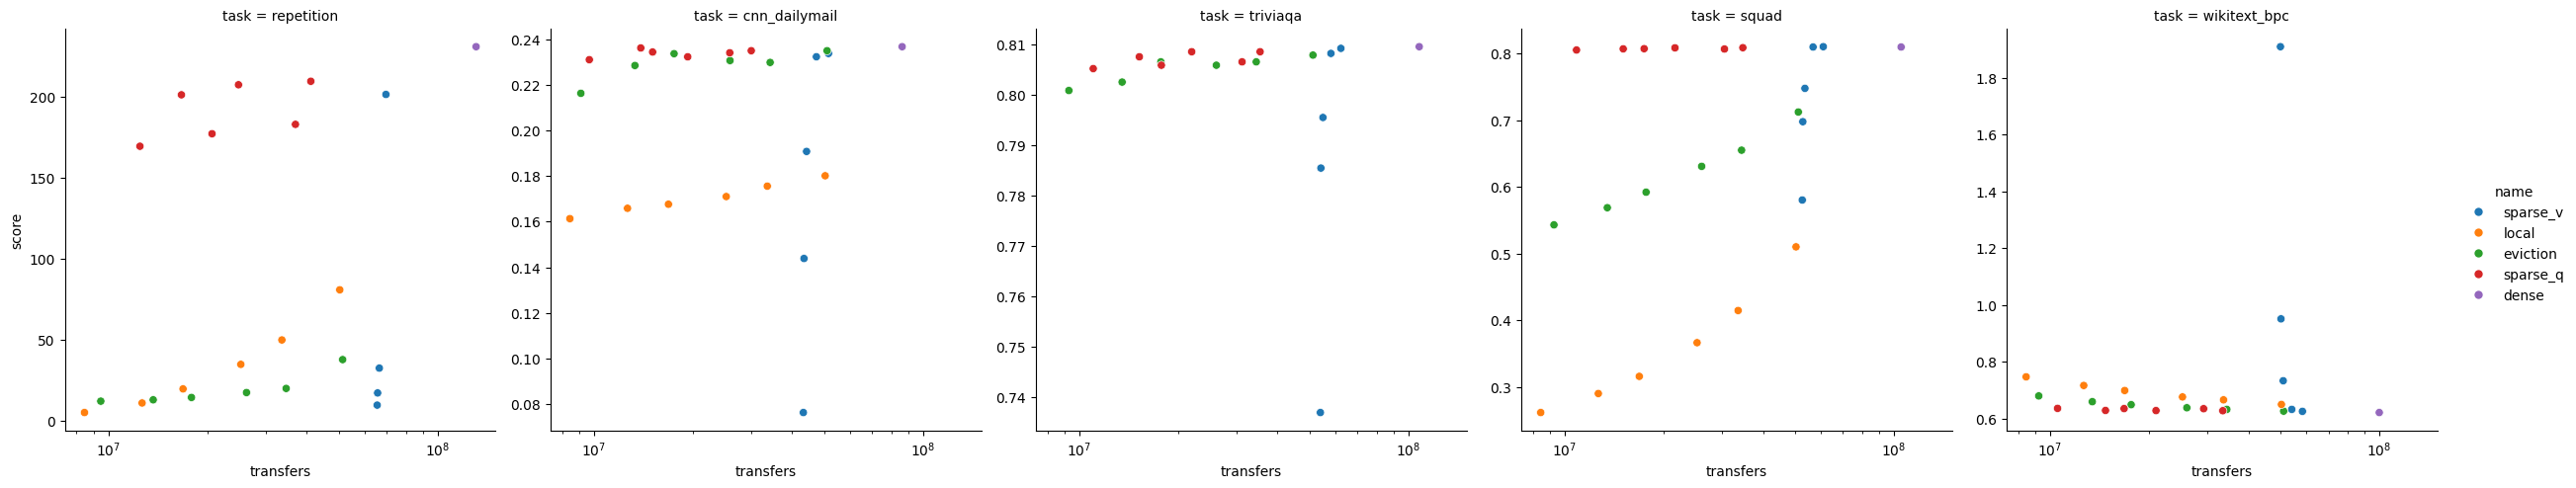

In [3]:
g = sns.relplot(data=df, x="transfers", y="score", col="task", hue="name", facet_kws=dict(sharex=True, sharey=False))
g.set(xscale="log")
plt.show()